# User Job Profiling
With this notebook, you can evaluate the user-job metrics collected by Slurm for your jobs. It allows you to view CPU, Memory, Energy, GPU, and other metric counters throughout your jobs runtime, in easily readable graphical form.

(c) Timon Vogt, GWDG, 2025

## Preparation & Monitoring

Before we can visualize job metrics, we have to collect them from a job. To do that, we can use the built-in Slurm performance profiling for jobs, available with the `--profile` flag.  
(*Please be aware, running a job with the `--profile` flag creates a performance overhead compared to running a job without it.*)

In your job's `sbatch` script, please add the following line at the top, below all the other `#SBATCH` lines:
```
#SBATCH --profile=all
```  

Here, we are using the profiling setting `all`. You can learn more about the available settings here: https://slurm.schedmd.com/sbatch.html#OPT_profile

Then, run the job. During the runtime of the job, Slurm will collect performance metrics and store them in a hdf5 file. Within this notebook, we will be reading this file and visualize the contained metrics.

## Imports & setup
This is the import cell, importing the required python packages. For this notebook, apart from the typical `os`, `sys` and `glob` packages, we need `h5py` to read hdf5 files, `matplotlib` to create graphs and `pandas` for data conversion. If this cell fails and the packages are not available, please contact an administrator.

In [85]:
import os
import sys
import glob
import h5py
import matplotlib.pyplot as plt
import pandas as pd

In the following line, set the variable `jobid` to the Slurm job id of the job you want to evaluate. It will then read the hdf5 file

In [95]:

#jobid = 9646276

#user = os.getenv("USER")
#files = glob.glob("/opt/misc/profiling/" + user + "/" + str(jobid) + "_*")
files = glob.glob('examples/*.h5')

print(files)
if len(files) == 0:
    print("Error: Cannot find a profiling file for jobid " + str(jobid) + ". Are you sure the job ran with the option --profile enabled?", file=sys.stderr)
# TODO: Handle multiple files
else:
    file = files[0]
    f = h5py.File(file, 'r')
    nodes = list(f.keys())
    for n in nodes:
        print("Node " + n + ": Tasks number: " + ', '.join([str(s) for s in f[n]['Tasks'].keys()]))


['examples\\9646276_batch_c0107.h5']
Node c0107: Tasks number: 0


## Reading the hdf5

A Slurm profiling dataset consists of timed measurements for each metric, done for each node and each task. Select here the node and the task you want to inspect:

In [93]:
node = 'c0107'
task = '0'
cores_used = 32


<HDF5 file "9646276_batch_c0107.h5" (mode r)>

## Raw data
This cell displays the raw data collected for the selected node and task

In [88]:
df = pd.DataFrame(f[node]['Tasks'][task][:])
df
df['CPUUtilization'] = df['CPUUtilization'] / cores_used


,ElapsedTime,EpochTime,CPUFrequency,CPUTime,CPUUtilization,GPUMemMB,GPUUtilization,RSS,VMSize,Pages,ReadMB,WriteMB
0,0,1751978609,2300,0.000,0.000000,10596176,0.000000e+00,0,0,0,0.000000,0.000000
1,30,1751978639,2300,0.140,0.466667,17592186044415,1.844674e+19,6620,0,0,1.745005,0.009249
2,60,1751978669,2300,0.000,0.000000,17592186044415,1.844674e+19,5828,0,0,0.000000,0.000000
3,60,1751978669,2300,0.001,0.000000,17592186044415,1.844674e+19,5224,0,0,0.000000,0.000000


## Ram usage

Simple plot, showing the RAM usage over time of the given task.

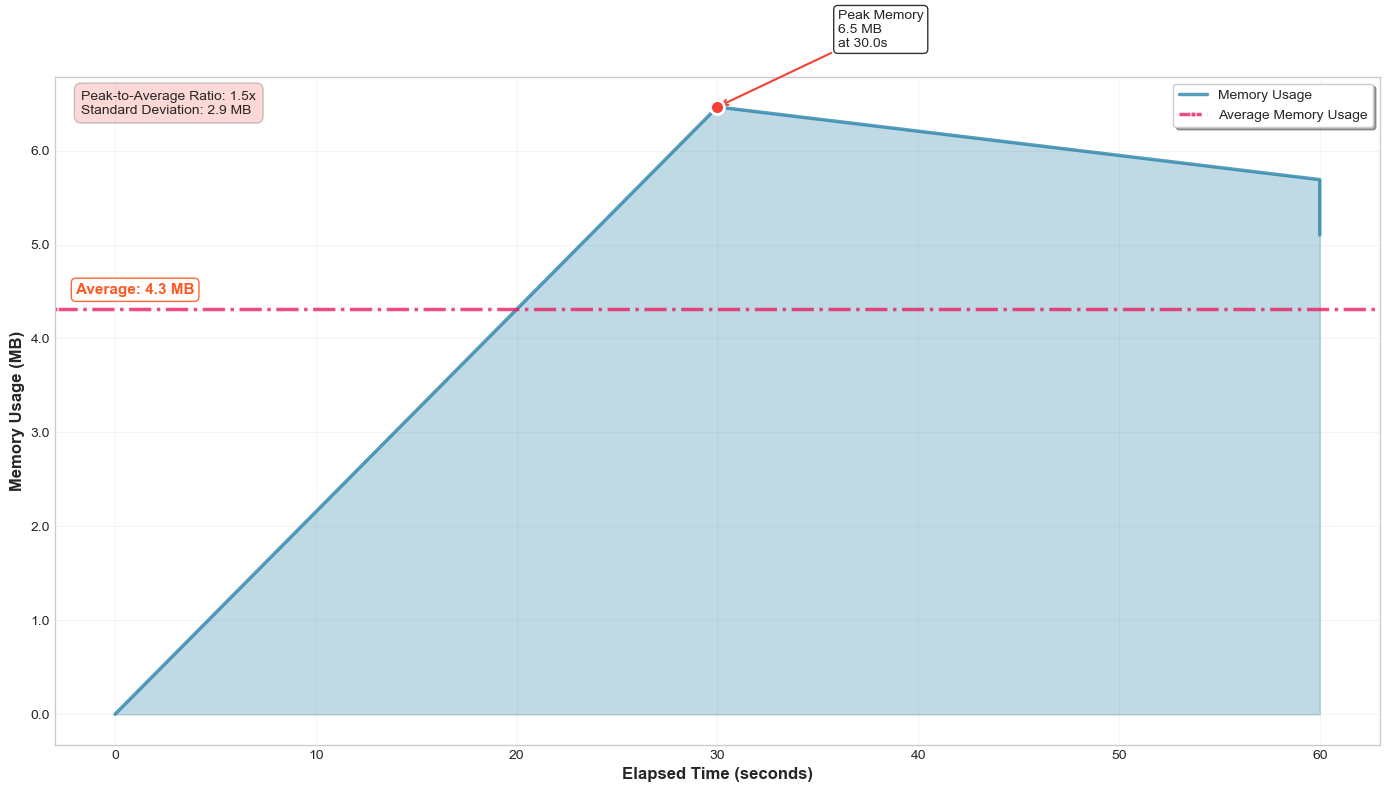

In [89]:

# Convert RSS to MB and calculate additional metrics
df['RSS_MB'] = df['RSS'] / 1024
peak_memory = df['RSS_MB'].max()
avg_memory = df['RSS_MB'].mean()
min_memory = df['RSS_MB'].min()
memory_std = df['RSS_MB'].std()

# Create figure with custom styling
plt.figure(figsize=(14, 8))
plt.style.use('seaborn-v0_8-whitegrid')

# Main memory usage line
plt.plot(df['ElapsedTime'], df['RSS_MB'],
         linewidth=2.5, color='#2E86AB', alpha=0.8, label='Memory Usage')


# Add gradient fill under the curve
plt.fill_between(df['ElapsedTime'], df['RSS_MB'],
                alpha=0.3, color='#2E86AB')

#average memory used line:
# Create a line with periodic markers
plt.axhline(y=avg_memory, color='#E91E63', linestyle='-.',
            linewidth=2.5, alpha=0.8,
            marker='o', markersize=4, markevery=20,
            markerfacecolor='#FF4081', markeredgecolor='white',
            markeredgewidth=1, label='Average Memory Usage')

plt.text(1, avg_memory + (peak_memory - min_memory) * 0.02,
         f'Average: {avg_memory:.1f} MB',
         ha='center', va='bottom', fontsize=11, fontweight='bold',
         color='#FF5722',
         bbox=dict(boxstyle="round,pad=0.3", facecolor="white",
                   edgecolor='#FF5722', alpha=0.9))



# Highlight peak usage point
peak_idx = df['RSS_MB'].idxmax()
peak_time = df.loc[peak_idx, 'ElapsedTime']
plt.scatter(peak_time, peak_memory,
           color='#F24236', s=100, zorder=5,
           marker='o', edgecolors='white', linewidth=2)

# Labels and grid
plt.xlabel('Elapsed Time (seconds)', fontsize=12, fontweight='bold')
plt.ylabel('Memory Usage (MB)', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
plt.legend(loc='best', frameon=True, fancybox=True, shadow=True, fontsize=10)

# Add text annotation for peak
plt.annotate(f'Peak Memory\n{peak_memory:.1f} MB\nat {peak_time:.1f}s',
            xy=(peak_time, peak_memory),
            xytext=(peak_time + (df['ElapsedTime'].max() - df['ElapsedTime'].min()) * 0.1,
                   peak_memory + (peak_memory - min_memory) * 0.1),
            arrowprops=dict(arrowstyle='->', color='#F24236', lw=1.5),
            fontsize=10, ha='left',
            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))


# Add efficiency text box
efficiency_text =f'Peak-to-Average Ratio: {peak_memory/avg_memory:.1f}x\n' \
                 f'Standard Deviation: {memory_std:.1f} MB'

plt.text(0.02, 0.98, efficiency_text, transform=plt.gca().transAxes,
         verticalalignment='top', fontsize=10,
         bbox=dict(boxstyle="round,pad=0.5", facecolor=efficiency_color, alpha=0.2))

# Format axes
plt.ticklabel_format(style='plain', axis='both')
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.0f}'))
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.1f}'))

# Adjust layout and show
plt.tight_layout()
plt.show()




## CPU usage
Simple plot, showing the CPU utilization over time of the given task. (Adjust `cores_used` to the number of cores the given task used)

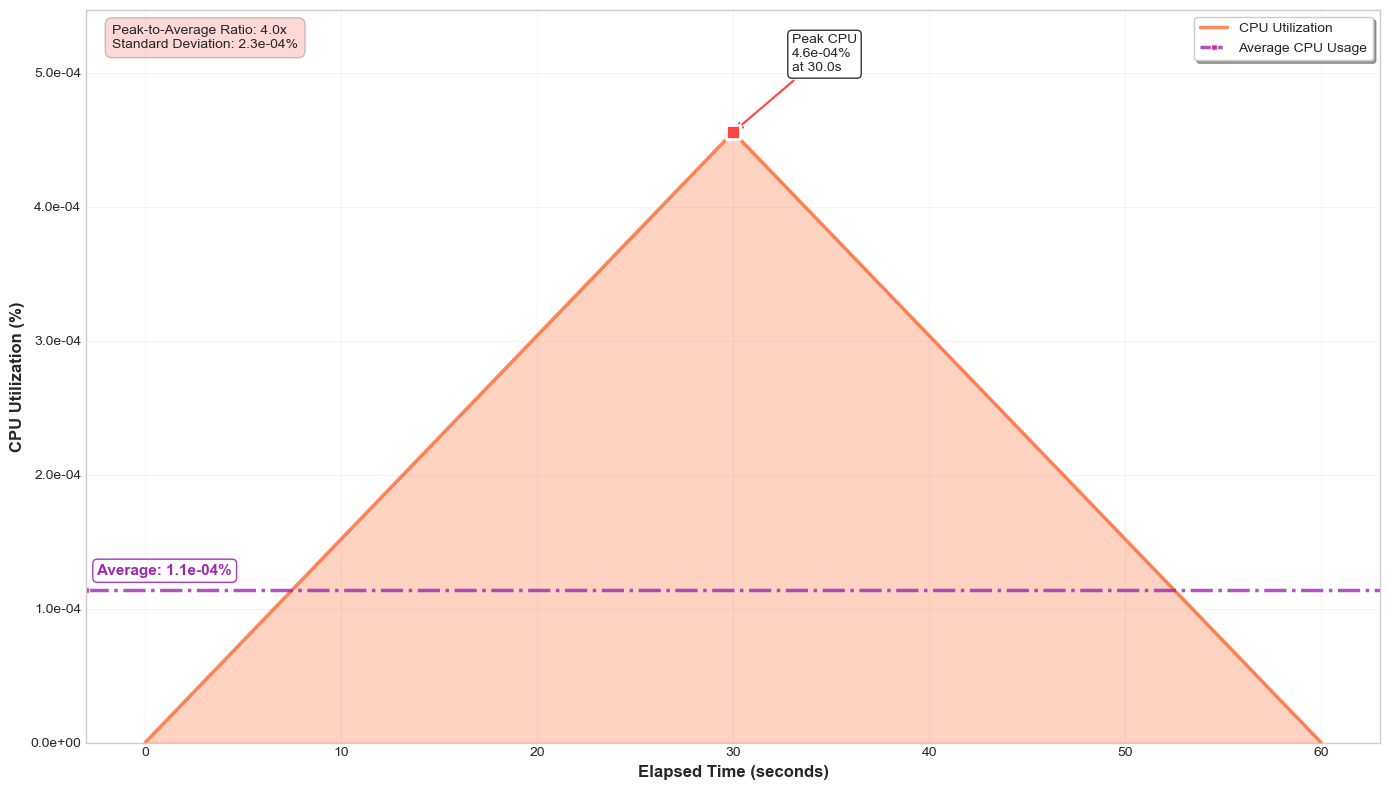

In [91]:


# Calculate CPU metrics
peak_cpu = df['CPUUtilization'].max()
avg_cpu = df['CPUUtilization'].mean()
min_cpu = df['CPUUtilization'].min()
cpu_std = df['CPUUtilization'].std()

def format_cpu_value(value):
    if value >= 1:
        return f'{value:.1f}%'
    elif value >= 0.1:
        return f'{value:.2f}%'
    elif value >= 0.01:
        return f'{value:.3f}%'
    else:
        return f'{value:.1e}%'  # Scientific notation for very small values

plt.figure(figsize=(14, 8))
plt.style.use('seaborn-v0_8-whitegrid')

# Main CPU utilization line w gradient
plt.plot(df['ElapsedTime'], df['CPUUtilization'],
         linewidth=2.5, color='#FF6B35', alpha=0.8, label='CPU Utilization')
plt.fill_between(df['ElapsedTime'], df['CPUUtilization'],
                alpha=0.3, color='#FF6B35')

# Average CPU usage line with text
plt.axhline(y=avg_cpu, color='#9C27B0', linestyle='-.',
            linewidth=2.5, alpha=0.8,
            marker='s', markersize=4, markevery=20,
            markerfacecolor='#E91E63', markeredgecolor='white',
            markeredgewidth=1, label='Average CPU Usage')
plt.text(1, avg_cpu + (peak_cpu - min_cpu) * 0.02,
         f'Average: {format_cpu_value(avg_cpu)}',
         ha='center', va='bottom', fontsize=11, fontweight='bold',
         color='#9C27B0',
         bbox=dict(boxstyle="round,pad=0.3", facecolor="white",
                   edgecolor='#9C27B0', alpha=0.9))

#peak usage point
peak_idx = df['CPUUtilization'].idxmax()
peak_time = df.loc[peak_idx, 'ElapsedTime']
plt.scatter(peak_time, peak_cpu,
           color='#FF4444', s=100, zorder=5,
           marker='s', edgecolors='white', linewidth=2)

# Labels and grid
plt.xlabel('Elapsed Time (seconds)', fontsize=12, fontweight='bold')
plt.ylabel('CPU Utilization (%)', fontsize=12, fontweight='bold')
plt.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
plt.legend(loc='best', frameon=True, fancybox=True, shadow=True, fontsize=10)

# Add text annotation for peak with smart formatting
plt.annotate(f'Peak CPU\n{format_cpu_value(peak_cpu)}\nat {peak_time:.1f}s',
            xy=(peak_time, peak_cpu),
            xytext=(peak_time + (df['ElapsedTime'].max() - df['ElapsedTime'].min()) * 0.05,
                   peak_cpu + (peak_cpu - min_cpu) * 0.1),
            arrowprops=dict(arrowstyle='->', color='#FF4444', lw=1.5),
            fontsize=10, ha='left',
            bbox=dict(boxstyle="round,pad=0.3", facecolor="white", alpha=0.8))

# Add efficiency text box with smart formatting
info_text =f'Peak-to-Average Ratio: {peak_cpu/avg_cpu:.1f}x\n' \
                 f'Standard Deviation: {format_cpu_value(cpu_std)}'

plt.text(0.02, 0.98, info_text, transform=plt.gca().transAxes,
         verticalalignment='top', fontsize=10,
         bbox=dict(boxstyle="round,pad=0.5", facecolor=efficiency_color, alpha=0.2))

# Format axes with smart formatting for y-axis
plt.ticklabel_format(style='plain', axis='both')
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.0f}'))

# y-axis formatting based on value range
if peak_cpu < 0.01:
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.1e}'))
elif peak_cpu < 0.1:
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.3f}'))
elif peak_cpu < 1:
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.2f}'))
else:
    plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.1f}'))

if peak_cpu < 1:
    plt.ylim(0, peak_cpu * 1.2)  # More zoom for low values
else:
    plt.ylim(0, min(100, peak_cpu * 1.1))

plt.tight_layout()
plt.show()

,ElapsedTime,EpochTime,NodePower
0,0,1751978609,264
1,0,1751978609,264
2,1,1751978610,264
3,2,1751978611,264
4,3,1751978612,264
...,...,...,...
60,59,1751978668,312
61,60,1751978669,312
62,61,1751978670,312
63,62,1751978671,312


KeyError: 'RSS'